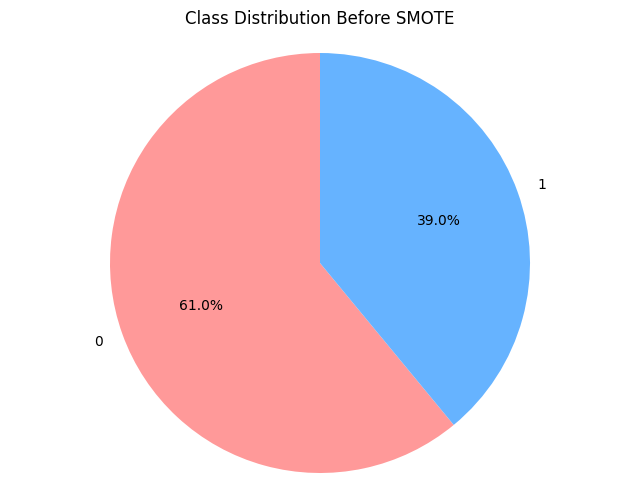

Class distribution before SMOTE:
Potability
0    1998
1    1278
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


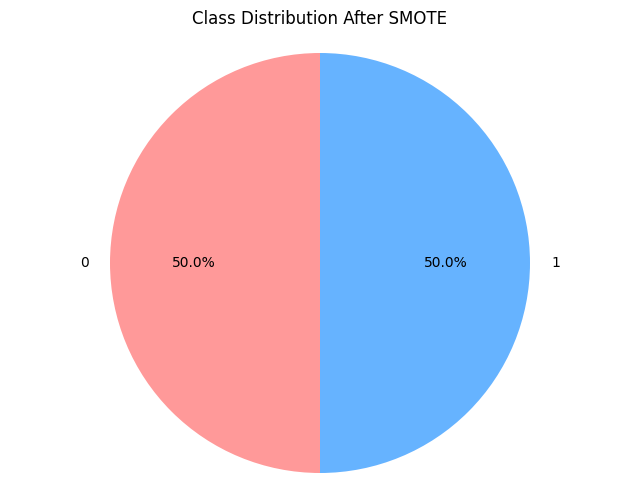

Class distribution after SMOTE:
Potability
0    1998
1    1998
Name: count, dtype: int64
Pattern Search completed without convergence.
Best Hyperparameters:
n_estimators: 82
max_depth: 16
min_samples_split: 10
min_samples_leaf: 9
Best Selected Features: Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object')
Accuracy: 0.9149291075896581
Precision: 0.918918918918919
Recall: 0.9096989966555183
F1 Score: 0.9142857142857143


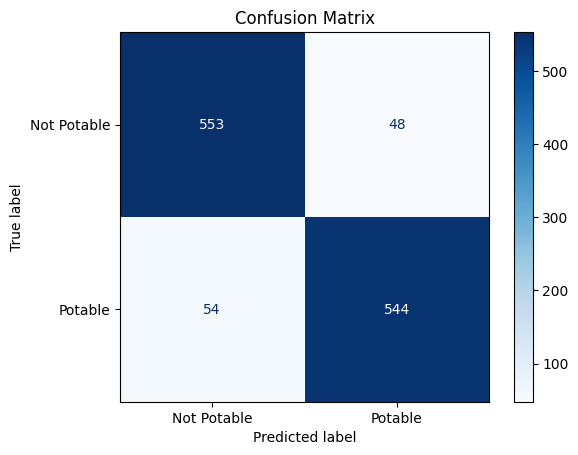

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay

# Chebyshev chaotic map with alpha = 8
def chebyshev_chaotic_map(x, alpha=8):
    return np.cos(alpha * np.arccos(x))

# Load and preprocess the dataset
df = pd.read_csv('/content/water_potability.csv')
df.isnull().sum()
imputer = SimpleImputer(strategy='mean')
df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])
X, y = df.iloc[:, :-1], df['Potability']

# Plot Pie Chart Before SMOTE
plt.figure(figsize=(8, 6))
y_value_counts = y.value_counts()
plt.pie(y_value_counts, labels=y_value_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title("Class Distribution Before SMOTE")
plt.axis('equal')
plt.show()

# Print distribution before SMOTE
print("Class distribution before SMOTE:")
print(y_value_counts)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Plot Pie Chart After SMOTE
plt.figure(figsize=(8, 6))
y_resampled_value_counts = y_resampled.value_counts()
plt.pie(y_resampled_value_counts, labels=y_resampled_value_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title("Class Distribution After SMOTE")
plt.axis('equal')
plt.show()

# Print distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_resampled_value_counts)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# HCPSA Parameters
num_features = X_train.shape[1]
num_iterations_stage1 = 50  # N (number of iterations in Stage I)
num_iterations_stage2 = 50  # Number of iterations in Stage II
U, L = 1, -1  # Bounds for the chaotic variable c_k
alpha = 8  # Parameter for Chebyshev map
c0 = 0.5  # Initial chaotic variable

# Initialize best solution variables
best_solution = None
best_score = -np.inf  # Initialize best score
best_scores_per_iteration = []

# Mapping function for Chebyshev map
def map_variables(c_k, L, U):
    return (U + L) / 2 + (U - L) / 2 * c_k

# Objective function
def objective_function(feature_mask, n_estimators, max_depth, min_samples_split, min_samples_leaf):
    selected_features = X_train.columns[feature_mask.astype(bool)]
    if len(selected_features) == 0:
        return 0
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)
    return accuracy_score(y_test, y_pred)

# Stage I: Chaotic Search
k = 1  # Initialize iteration counter
c_k = np.full(num_features, c0)  # Initialize chaotic variable with c0 = 0.5

while k <= num_iterations_stage1:  # If k ≤ N, proceed; otherwise, exit
    # Map chaotic variables to feature space
    feature_mask = map_variables(c_k, L, U)

    # Map chaotic variables to hyperparameters
    n_estimators = int(10 + (np.mean(feature_mask) + 1) / 2 * 90)  # Map to [10, 100]
    max_depth = int(2 + (np.mean(feature_mask) + 1) / 2 * 18)       # Map to [2, 20]
    min_samples_split = int(2 + (np.mean(feature_mask) + 1) / 2 * 10)  # Map to [2, 12]
    min_samples_leaf = int(1 + (np.mean(feature_mask) + 1) / 2 * 10)   # Map to [1, 11]

    # Evaluate solution using the objective function
    score = objective_function(
        (feature_mask > 0).astype(int),  # Convert mask to binary (selected features)
        n_estimators,
        max_depth,
        min_samples_split,
        min_samples_leaf
    )

    # Update the best solution if the score improves
    if score > best_score:
        best_score = score
        best_solution = (feature_mask.copy(), n_estimators, max_depth, min_samples_split, min_samples_leaf)

    best_scores_per_iteration.append(best_score)  # Add this line to store the scores

    # Update chaotic variables using the Chebyshev chaotic map
    c_k = chebyshev_chaotic_map(c_k, alpha)

    # Increment the counter `k`
    k += 1  # Proceed to the next iteration

# Output of Stage I: X_max
X_max = best_solution[0]  # Best feature mask from Stage I

# Stage II: Pattern Search with Convergence Check and Step Size Reduction
import numpy as np

def pattern_search(X_0, num_iterations, epsilon=1e-3):
    delta = 0.5  # Initial step size
    X_opt = X_0.copy()  # Initialize current optimal point
    f_opt = objective_function(X_opt, n_estimators, max_depth, min_samples_split, min_samples_leaf)  # Initialize best objective value
    X_prev = None  # Store the previous base point for pattern move
    convergence_reached = False  # Convergence flag

    for k in range(1, num_iterations + 1):  # Iterate for Stage II
        improved = False  # Track if improvement is found during this iteration
        Y_k_n = X_opt.copy()  # Start exploratory move with current base point

        # Step 2: Exploratory Move using Unit Vectors
        for i in range(len(X_opt)):  # Explore each dimension
            # Define the unit vector for the current dimension
            u_i = np.zeros(len(X_opt))
            u_i[i] = 1  # Unit vector for the i-th coordinate

            # Increment and decrement delta in the i-th direction
            X_inc = Y_k_n + delta * u_i
            X_dec = Y_k_n - delta * u_i

            # Calculate hyperparameters for X_inc and X_dec
            n_estimators_inc = int(10 + (np.mean(X_inc) + 1) / 2 * 90)
            max_depth_inc = int(2 + (np.mean(X_inc) + 1) / 2 * 18)
            min_samples_split_inc = int(2 + (np.mean(X_inc) + 1) / 2 * 10)
            min_samples_leaf_inc = int(1 + (np.mean(X_inc) + 1) / 2 * 10)

            n_estimators_dec = int(10 + (np.mean(X_dec) + 1) / 2 * 90)
            max_depth_dec = int(2 + (np.mean(X_dec) + 1) / 2 * 18)
            min_samples_split_dec = int(2 + (np.mean(X_dec) + 1) / 2 * 10)
            min_samples_leaf_dec = int(1 + (np.mean(X_dec) + 1) / 2 * 10)

            # Evaluate the objective function at incremented and decremented points
            f_inc = objective_function(X_inc, n_estimators_inc, max_depth_inc, min_samples_split_inc, min_samples_leaf_inc)
            f_dec = objective_function(X_dec, n_estimators_dec, max_depth_dec, min_samples_split_dec, min_samples_leaf_dec)

            # Update Y_k_n based on the conditions in Step 2
            if f_inc > max(f_opt, f_dec):
                Y_k_n = X_inc
                f_opt = f_inc
                improved = True
            elif f_dec > max(f_opt, f_inc):
                Y_k_n = X_dec
                f_opt = f_dec
                improved = True

        # Step 2 Check: If f(Y_k,n) > f(Y_k,0), update X_k+1 and go to Step 4
        n_estimators_opt = int(10 + (np.mean(X_opt) + 1) / 2 * 90)
        max_depth_opt = int(2 + (np.mean(X_opt) + 1) / 2 * 18)
        min_samples_split_opt = int(2 + (np.mean(X_opt) + 1) / 2 * 10)
        min_samples_leaf_opt = int(1 + (np.mean(X_opt) + 1) / 2 * 10)
        if f_opt < objective_function(X_opt,n_estimators_opt, max_depth_opt, min_samples_split_opt, min_samples_leaf_opt):  # Improvement found
            X_prev = X_opt  # Update the previous base point
            X_opt = Y_k_n  # Update optimal point to Y_k,n

            # Step 4: Perform Pattern Move
            if X_prev is not None:
                # Compute pattern move using unit vector
                X_pattern = 2 * X_opt - X_prev
                # Calculate hyperparameters for X_pattern
                n_estimators_pattern = int(10 + (np.mean(X_pattern) + 1) / 2 * 90)
                max_depth_pattern = int(2 + (np.mean(X_pattern) + 1) / 2 * 18)
                min_samples_split_pattern = int(2 + (np.mean(X_pattern) + 1) / 2 * 10)
                min_samples_leaf_pattern = int(1 + (np.mean(X_pattern) + 1) / 2 * 10)

                f_pattern = objective_function(X_pattern,n_estimators_pattern,max_depth_pattern,min_samples_split_pattern,min_samples_leaf_pattern)
                if f_pattern > f_opt:  # Update only if pattern move improves
                    X_prev = X_opt
                    X_opt = X_pattern
                    f_opt = f_pattern

            # Step 5: Exploratory Move with New Base Point (X_opt after pattern move)
            Y_k1_0 = X_opt  # New base point after pattern move
            Y_k1_n = Y_k1_0.copy()  # Start exploratory move from new base point

            # Perform exploratory move using the new base point
            for i in range(len(Y_k1_0)):  # Explore each dimension
                u_i = np.zeros(len(Y_k1_0))
                u_i[i] = 1  # Unit vector for the i-th coordinate

                X_inc = Y_k1_n + delta * u_i
                X_dec = Y_k1_n - delta * u_i
          # Calculate hyperparameters for X_inc and X_dec
                n_estimators_inc = int(10 + (np.mean(X_inc) + 1) / 2 * 90)
                max_depth_inc = int(2 + (np.mean(X_inc) + 1) / 2 * 18)
                min_samples_split_inc = int(2 + (np.mean(X_inc) + 1) / 2 * 10)
                min_samples_leaf_inc = int(1 + (np.mean(X_inc) + 1) / 2 * 10)

                n_estimators_dec = int(10 + (np.mean(X_dec) + 1) / 2 * 90)
                max_depth_dec = int(2 + (np.mean(X_dec) + 1) / 2 * 18)
                min_samples_split_dec = int(2 + (np.mean(X_dec) + 1) / 2 * 10)
                min_samples_leaf_dec = int(1 + (np.mean(X_dec) + 1) / 2 * 10)

                f_inc = objective_function(X_inc,n_estimators_inc, max_depth_inc, min_samples_split_inc, min_samples_leaf_inc)
                f_dec = objective_function(X_dec,n_estimators_dec, max_depth_dec, min_samples_split_dec, min_samples_leaf_dec)

                # Update Y_k1_n based on the best value
                if f_inc > max(f_opt, f_dec):
                    Y_k1_n = X_inc
                    f_opt = f_inc
                elif f_dec > max(f_opt, f_inc):
                    Y_k1_n = X_dec
                    f_opt = f_dec

            # Calculate hyperparameters based on X_opt
            n_estimators_opt = int(10 + (np.mean(X_opt) + 1) / 2 * 90)
            max_depth_opt = int(2 + (np.mean(X_opt) + 1) / 2 * 18)
            min_samples_split_opt = int(2 + (np.mean(X_opt) + 1) / 2 * 10)
            min_samples_leaf_opt = int(1 + (np.mean(X_opt) + 1) / 2 * 10)

            # After Step 5, check if improvement has occurred (Step 6)
            if f_opt > objective_function(X_opt, n_estimators_opt, max_depth_opt, min_samples_split_opt, min_samples_leaf_opt):
                X_prev = X_opt
                X_opt = Y_k1_n  # Update optimal point to the new exploratory point
            else:
          # If no improvement, reduce delta as per Step 3
                delta /= 2
                if delta < epsilon:
                    print(f"Converged at iteration {k}: f_opt = {f_opt:.5f}")
                    convergence_reached = True
                    break

                else:
            # Step 3: If no improvement, reduce delta
                    delta /= 2
            if delta < epsilon:  # Convergence condition
                print(f"Converged at iteration {k}: f_opt = {f_opt:.5f}")
                convergence_reached = True
                break

    if not convergence_reached:
        print("Pattern Search completed without convergence.")

    return X_opt, f_opt

# Use X_max as the initial point for Stage II
best_selected_features, best_hyperparams = pattern_search(X_max, num_iterations_stage2, epsilon=1e-3)

# Print best hyperparameters and features
print("Best Hyperparameters:")
print("n_estimators:", int(10 + (np.mean(best_selected_features) + 1) / 2 * 90))
print("max_depth:", int(2 + (np.mean(best_selected_features) + 1) / 2 * 18))
print("min_samples_split:", int(2 + (np.mean(best_selected_features) + 1) / 2 * 10))
print("min_samples_leaf:", int(1 + (np.mean(best_selected_features) + 1) / 2 * 10))
print("Best Selected Features:", X.columns[best_selected_features.astype(bool)])

# Train final model with best features and hyperparameters
final_clf = RandomForestClassifier(
    n_estimators=int(10 + (np.mean(best_selected_features) + 1) / 2 * 90),
    max_depth=int(2 + (np.mean(best_selected_features) + 1) / 2 * 18),
    min_samples_split=int(2 + (np.mean(best_selected_features) + 1) / 2 * 10),
    min_samples_leaf=int(1 + (np.mean(best_selected_features) + 1) / 2 * 10),
    random_state=42
)

# Train final model on the full dataset
selected_feature_indices = np.where(best_selected_features)[0]
final_clf.fit(X_resampled.iloc[:, selected_feature_indices], y_resampled)

# Evaluate the model
selected_feature_indices = np.where(best_selected_features)[0] # Get indices of selected features
y_pred = final_clf.predict(X_test.iloc[:, selected_feature_indices]) # Filter X_test using indices
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=['Not Potable', 'Potable']).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

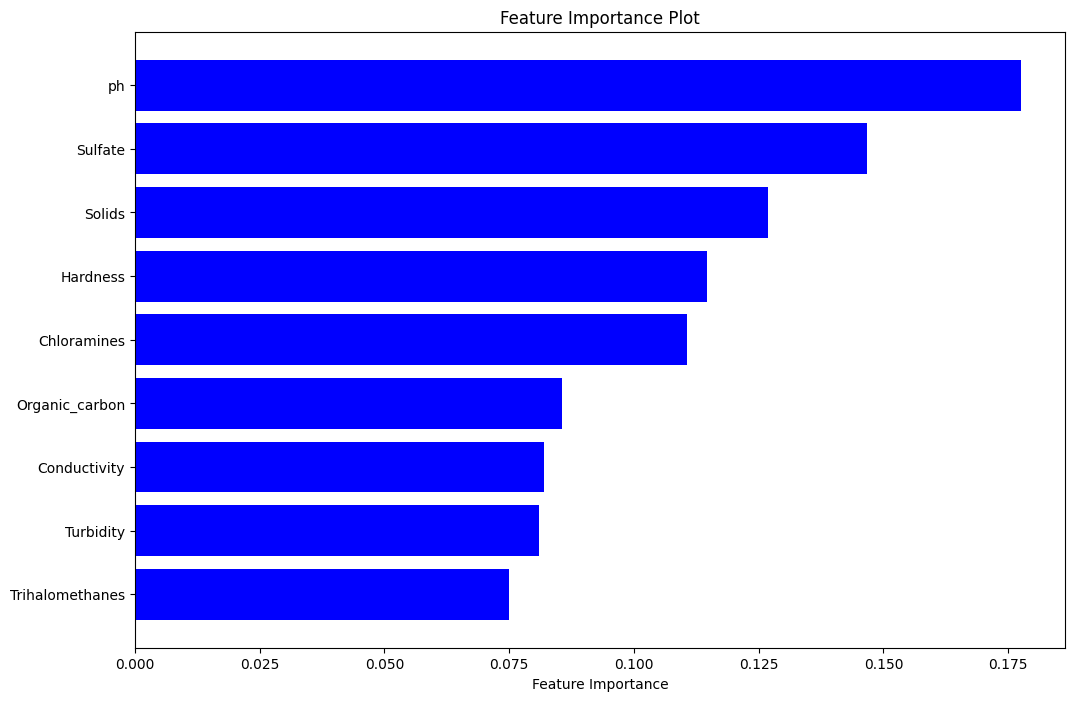

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# Get selected feature names
selected_feature_names = X_resampled.columns[best_selected_features.astype(bool)]

# Plot Feature Importance
importances = final_clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), selected_feature_names[indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()